In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.dates as mdates
import torch.nn.functional as F
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error, r2_score
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
Data = pd.read_excel("QBO Data.xlsx")
Data['Date'] = pd.to_datetime(Data['Date'], format='%d%m%Y')
Data.set_index('Date', inplace=True)

data = Data[['25 hPa']]  # Ini penting: index datetime tetap dipertahankan

In [3]:
data.head()

,25 hPa
Date,
1987-01-01,-289
1987-02-01,-280
1987-03-01,-309
1987-04-01,-303
1987-05-01,-289


In [4]:
data.shape

(419, 1)

In [5]:
data.columns

Index(['25 hPa'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 1987-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   25 hPa  419 non-null    int64
dtypes: int64(1)
memory usage: 6.5 KB


In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=28).mean()
    MSTD = timeseries.rolling(window=28).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

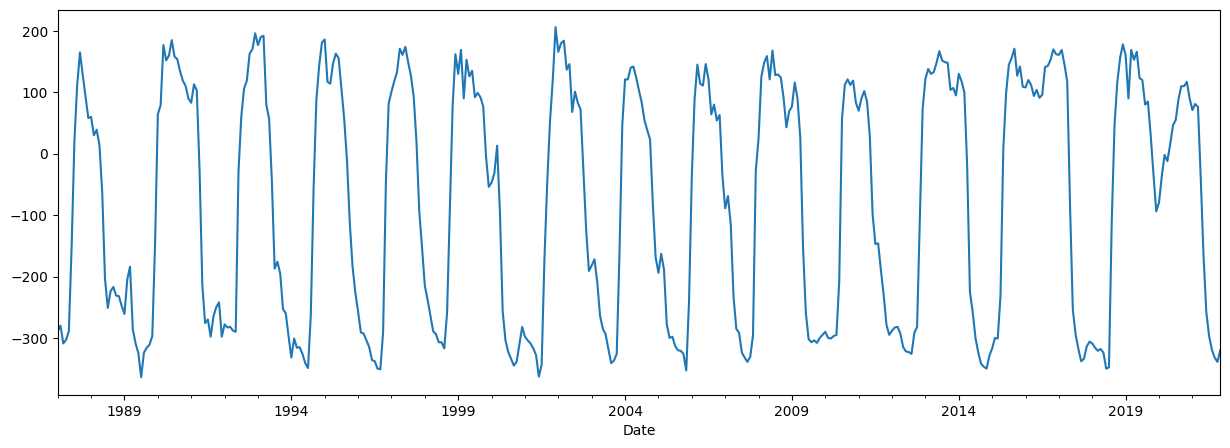

In [9]:
plt.figure(figsize = (15,5))
data['25 hPa'].plot();

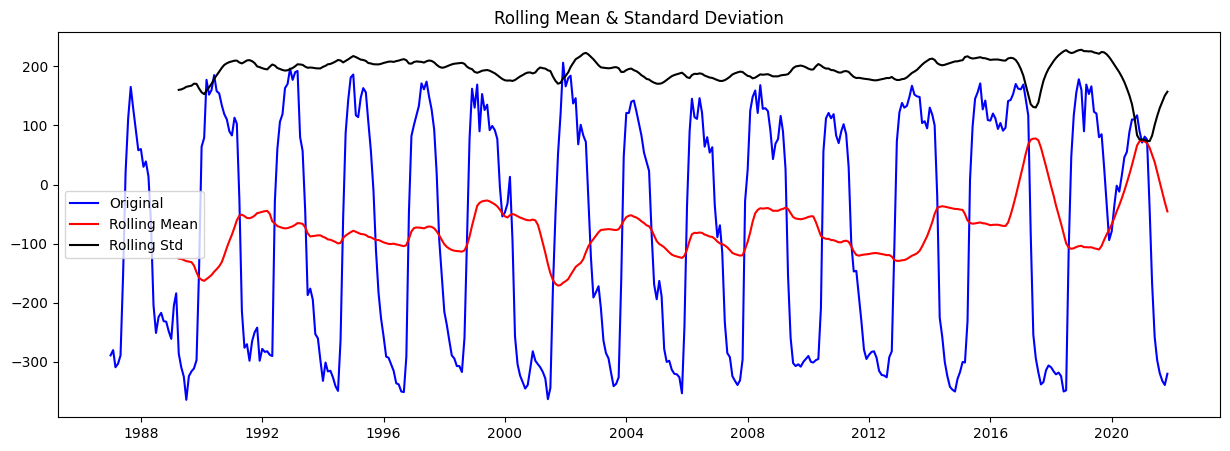

Results of Dickey-Fuller Test:
Test Statistic                -8.942076e+00
p-value                        9.195652e-15
#Lags Used                     1.100000e+01
Number of Observations Used    4.070000e+02
Critical Value (1%)           -3.446520e+00
Critical Value (5%)           -2.868668e+00
Critical Value (10%)          -2.570567e+00
dtype: float64


In [10]:
test_stationarity(data['25 hPa'])

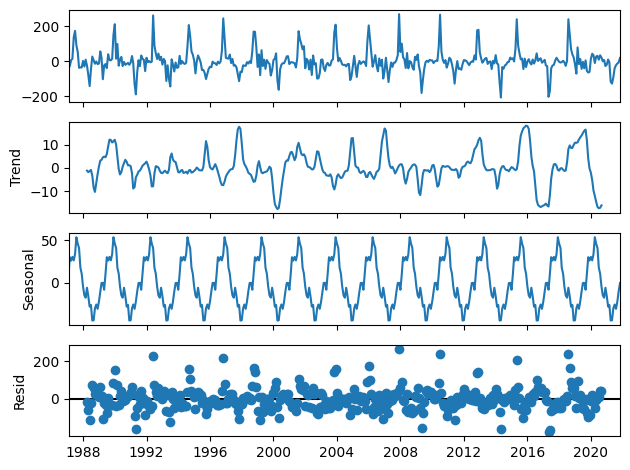

In [11]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 28).plot()
plt.show()

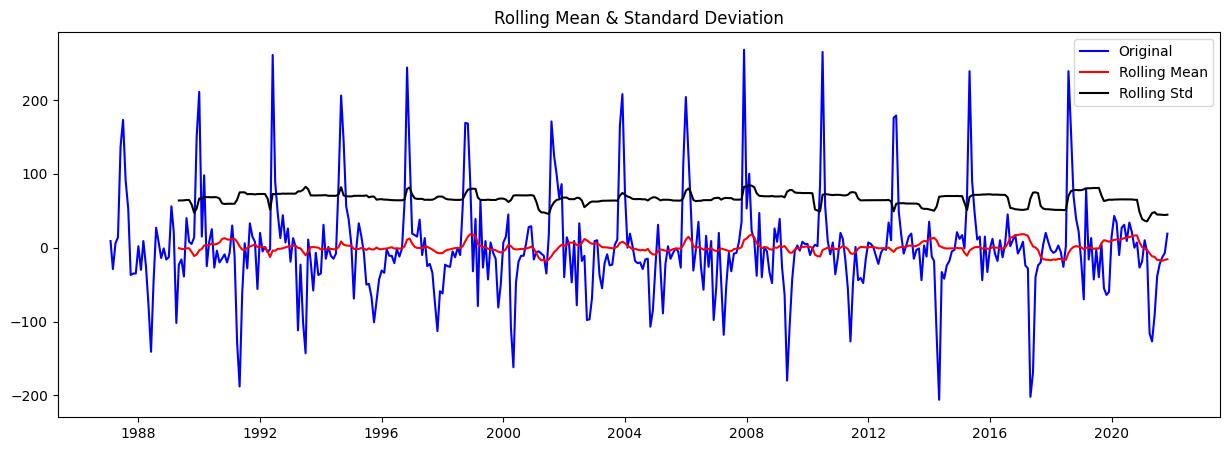

Results of Dickey-Fuller Test:
Test Statistic                -9.116292e+00
p-value                        3.295583e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.000000e+02
Critical Value (1%)           -3.446804e+00
Critical Value (5%)           -2.868793e+00
Critical Value (10%)          -2.570634e+00
dtype: float64


In [12]:
test_stationarity(data_diff)

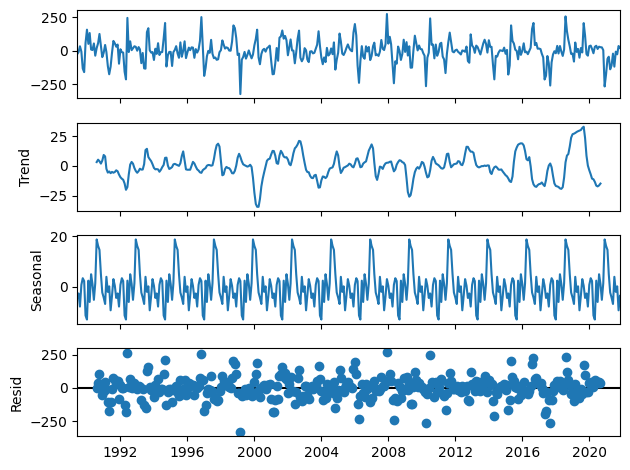

In [13]:
data_diff_seas = data_diff.diff(28)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 28)
dec.plot()
plt.show()

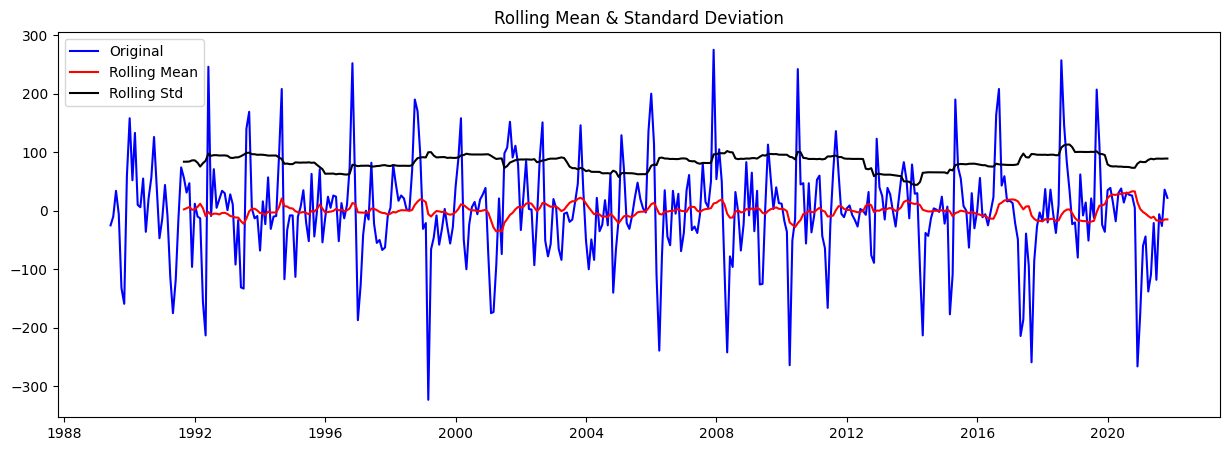

Results of Dickey-Fuller Test:
Test Statistic                -1.174556e+01
p-value                        1.243920e-21
#Lags Used                     2.000000e+00
Number of Observations Used    3.870000e+02
Critical Value (1%)           -3.447361e+00
Critical Value (5%)           -2.869037e+00
Critical Value (10%)          -2.570764e+00
dtype: float64


In [14]:
test_stationarity(data_diff_seas['25 hPa'])

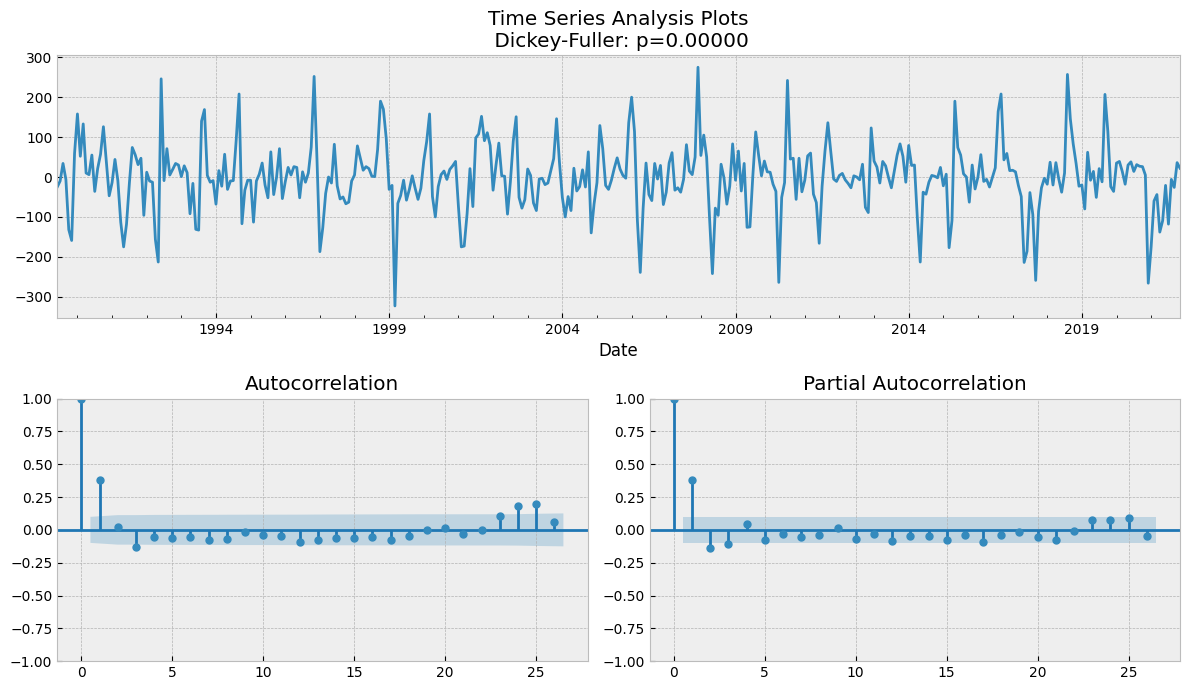

In [15]:
tsplot(data_diff_seas['25 hPa'])

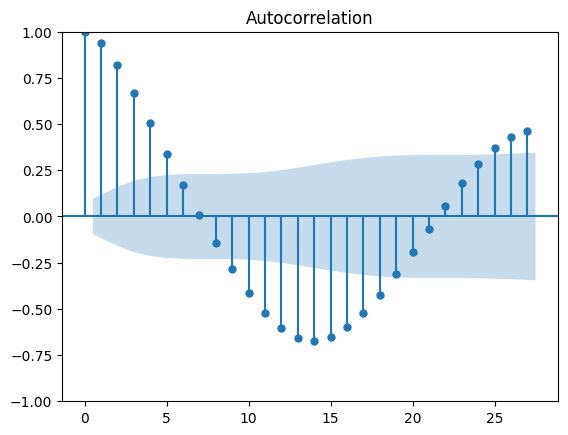

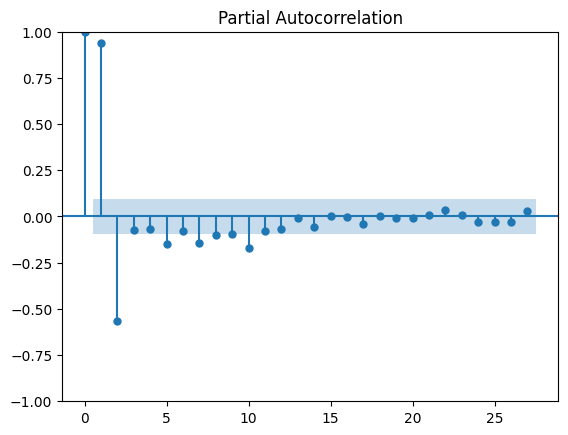

In [16]:
plot_acf(data)
plot_pacf(data)
plt.show()

In [17]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA  # Ganti SARIMAX ke ARIMA

# Misal: data sudah dalam format time series dan bernama data
# data harus berupa Series dengan index berupa datetime
# Contoh:
# data = pd.read_csv("yourfile.csv", index_col='Date', parse_dates=True)

# Parameter ranges (hanya p, d, q karena ini ARIMA)
p = d = q = range(0, 6)  # (p, d, q) dari 0 hingga 6

# Generate semua kombinasi parameter
pdq = list(itertools.product(p, d, q))

# Untuk menyimpan hasil AIC
results = []

# Grid search (tanpa seasonal_order)
for param in pdq:
    try:
        model = ARIMA(data, order=param)  # Gunakan ARIMA, bukan SARIMAX
        results_fit = model.fit()
        results.append({
            'order': param,
            'AIC': results_fit.aic
        })
    except Exception as e:
        print(f"Error pada parameter {param}: {str(e)}")
        continue

# Konversi ke DataFrame dan sortir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

# Tampilkan model terbaik
print("Model ARIMA terbaik berdasarkan AIC:")
print(results_df.head(1))

# Jika ingin semua model disortir berdasarkan AIC
print("\nTop 5 model dengan AIC terendah:")
print(results_df.head(5))

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-

Model ARIMA terbaik berdasarkan AIC:
       order          AIC
0  (5, 1, 2)  4472.280647

Top 5 model dengan AIC terendah:
       order          AIC
0  (5, 1, 2)  4472.280647
1  (3, 1, 5)  4473.749536
2  (5, 0, 2)  4474.622006
3  (4, 0, 3)  4474.686501
4  (5, 0, 1)  4475.138070


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
from statsmodels.tsa.arima.model import ARIMA  # Import ARIMA

# Fit model ARIMA (tanpa komponen musiman)
model = ARIMA(data,
              order=(5, 1, 2))  # Hanya gunakan order=(p, d, q)

model_fit = model.fit()

# Ringkasan model
print(model_fit.summary())

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 25 hPa   No. Observations:                  419
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2228.140
Date:                Wed, 23 Jul 2025   AIC                           4472.281
Time:                        01:31:08   BIC                           4504.564
Sample:                    01-01-1987   HQIC                          4485.043
                         - 11-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2482      0.058     38.498      0.000       2.134       2.363
ar.L2         -1.7128      0.114    -14.975      0.000      -1.937      -1.489
ar.L3          0.4019      0.145      2.769      0.0

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Hasil koefisien dari model_fit ARIMA
phi1 = 2.2482  # AR(1) coefficient
phi2 = -1.7128  # AR(2) coefficient
phi3 = 0.4019   # AR(3) coefficient
phi4 = 0.1438   # AR(4) coefficient
phi5 = -0.1208  # AR(5) coefficient
theta1 = -1.8729  # MA(1) coefficient
theta2 = 0.8766   # MA(2) coefficient

# Tampilkan rumus ARIMA dalam format panjang
print("Rumus ARIMA(5,1,2) dalam Format Panjang:")
print(f"""
    (1-B)Y_t = (1 + {phi1:+.4f})(1-B)Y_(t-1) + ({phi2:+.4f} - {phi1:+.4f})(1-B)Y_(t-2) 
        + ({phi3:+.4f} - {phi2:+.4f})(1-B)Y_(t-3) + ({phi4:+.4f} - {phi3:+.4f})(1-B)Y_(t-4)
        + ({phi5:+.4f} - {phi4:+.4f})(1-B)Y_(t-5) - ({phi5:+.4f})(1-B)Y_(t-6)
        + 0 + {theta1:+.4f}e_(t-1) + {theta2:+.4f}e_(t-2)
""")

# Versi setelah perhitungan
print("Setelah dihitung:")
print(f"""
(1-B)Y_t = {1+phi1:+.4f}(1-B)Y_(t-1) {phi2-phi1:+.4f}(1-B)Y_(t-2) {phi3-phi2:+.4f}(1-B)Y_(t-3)
        {phi4-phi3:+.4f}(1-B)Y_(t-4) {phi5-phi4:+.4f}(1-B)Y_(t-5) {-phi5:+.4f}(1-B)Y_(t-6)
        + e_t {theta1:+.4f}e_(t-1) {theta2:+.4f}e_(t-2)
""")
                                            
# Penjelasan:
# (1-B)Y_t = differencing pertama (Y_t - Y_(t-1))
# e_t = error term pada waktu t

Rumus ARIMA(5,1,2) dalam Format Panjang:

    (1-B)Y_t = (1 + +2.2482)(1-B)Y_(t-1) + (-1.7128 - +2.2482)(1-B)Y_(t-2) 
        + (+0.4019 - -1.7128)(1-B)Y_(t-3) + (+0.1438 - +0.4019)(1-B)Y_(t-4)
        + (-0.1208 - +0.1438)(1-B)Y_(t-5) - (-0.1208)(1-B)Y_(t-6)
        + 0 + -1.8729e_(t-1) + +0.8766e_(t-2)

Setelah dihitung:

(1-B)Y_t = +3.2482(1-B)Y_(t-1) -3.9610(1-B)Y_(t-2) +2.1147(1-B)Y_(t-3)
        -0.2581(1-B)Y_(t-4) -0.2646(1-B)Y_(t-5) +0.1208(1-B)Y_(t-6)
        + e_t -1.8729e_(t-1) +0.8766e_(t-2)



In [20]:
# Split data menjadi data latih dan data uji 70:30
from sklearn.model_selection import train_test_split
train, test = data.iloc[:int(len(data)*0.7)], data.iloc[int(len(data)*0.7):]

In [21]:
train_pred = model_fit.predict(start=0, end=len(train)-1, dynamic=False)
test_pred = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Atur ulang index prediksi agar sama dengan data aslinya (datetime)
train_pred.index = train.index
test_pred.index = test.index

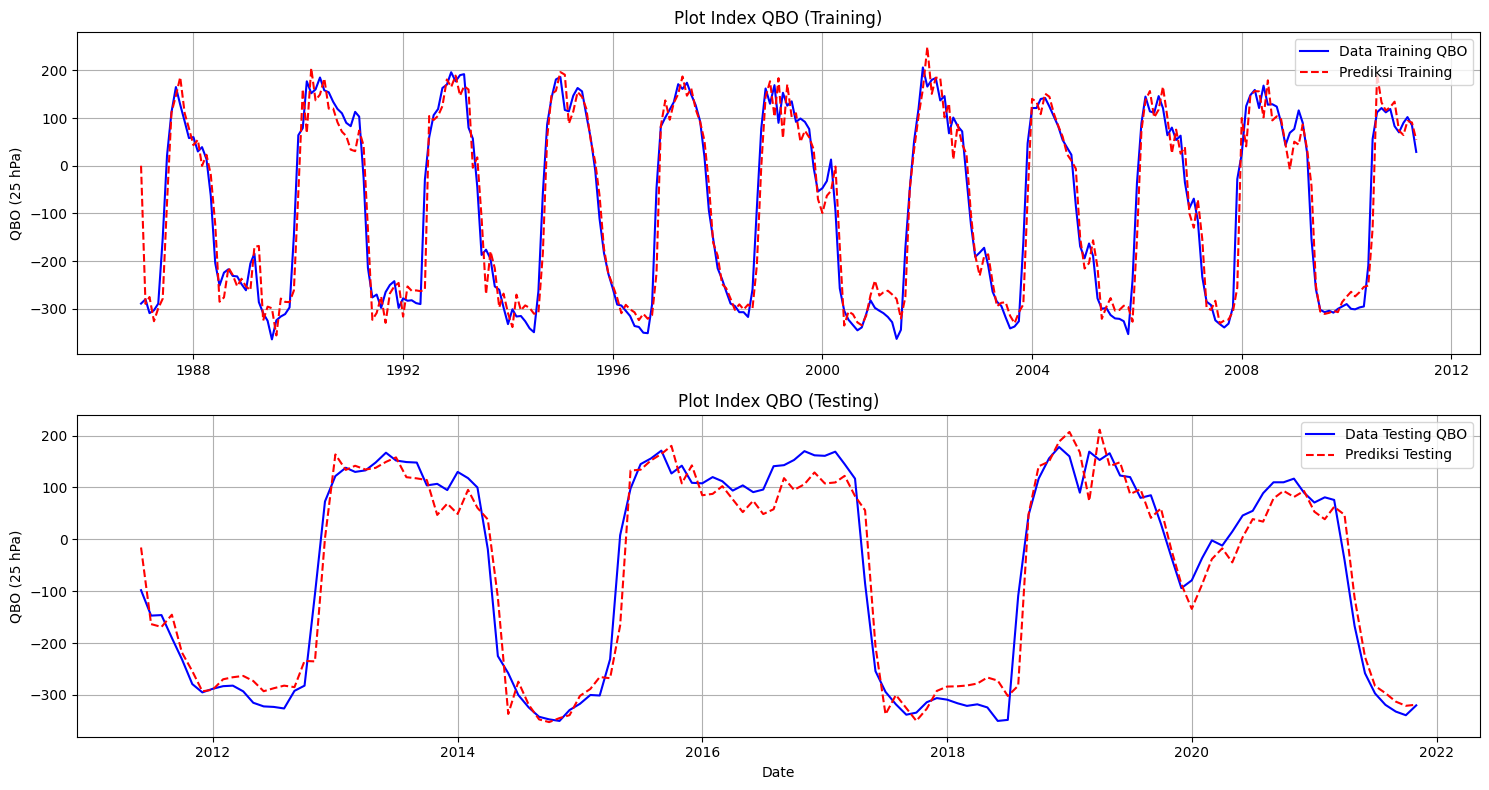

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=False)

# Subplot untuk data training
axs[0].plot(train.index, train, label='Data Training QBO', color='blue')
axs[0].plot(train.index, train_pred, label='Prediksi Training', color='red', linestyle='--')
axs[0].set_title("Plot Index QBO (Training)", fontsize=12)
axs[0].set_ylabel("QBO (25 hPa)")
axs[0].legend()
axs[0].grid(True)

# Subplot untuk data testing
axs[1].plot(test.index, test, label='Data Testing QBO', color='blue')
axs[1].plot(test.index, test_pred, label='Prediksi Testing', color='red', linestyle='--')
axs[1].set_title("Plot Index QBO (Testing)", fontsize=12)
axs[1].set_xlabel("Date")
axs[1].set_ylabel("QBO (25 hPa)")
axs[1].legend()
axs[1].grid(True)

# Tampilkan
plt.tight_layout()
plt.show()

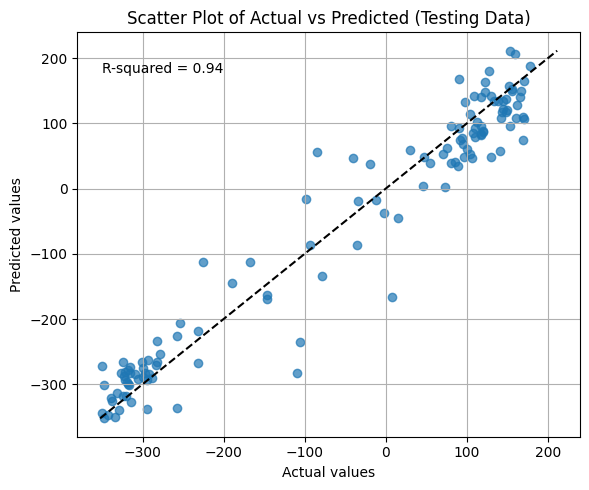

In [23]:
# Pastikan data dalam bentuk array 1D
y_test_actual = np.array(test)
y_test_pred = np.array(test_pred)

# Hitung R-squared
r2 = r2_score(y_test_actual, y_test_pred)

# Scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test_actual, y_test_pred, alpha=0.7)

# Garis referensi (prediksi sempurna)
min_val = min(y_test_actual.min(), y_test_pred.min())
max_val = max(y_test_actual.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs Predicted (Testing Data)")

# Tampilkan nilai R² di dalam plot
plt.text(0.05, 0.90, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)

plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# MSE (Mean Squared Error)                          % Data Training
mse_train = mean_squared_error(train, train_pred)
# RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mse_train)
# MAE (Mean Absolute Error)
mae_train = mean_absolute_error(train, train_pred)
# R2 (Coefficient of Determination)
r2_train = r2_score(train, train_pred)

# MSE (Mean Squared Error)                          % Data Testing
mse_test = mean_squared_error(test, test_pred)
# RMSE (Root Mean Squared Error)
rmse_test = np.sqrt(mse_test)
# MAE (Mean Absolute Error)
mae_test = mean_absolute_error(test, test_pred)
# R2 (Coefficient of Determination)
r2_test = r2_score(test, test_pred)

# Display metrics in a DataFrame
metrics_data = {
    'Metric': ['R\N{SUPERSCRIPT TWO}', 'MAE', 'MSE', 'RMSE'],
    'Train Data': [r2_train, mae_train, mse_train, rmse_train],
    'Test Data': [r2_test, mae_test, mse_test, rmse_test]}

metrics_qbo = pd.DataFrame(metrics_data)
metrics_qbo = metrics_qbo.round(4)

print(metrics_qbo)

  Metric  Train Data  Test Data
0     R²      0.9227     0.9425
1    MAE     37.3436    35.6201
2    MSE   2841.3758  2256.5827
3   RMSE     53.3046    47.5035


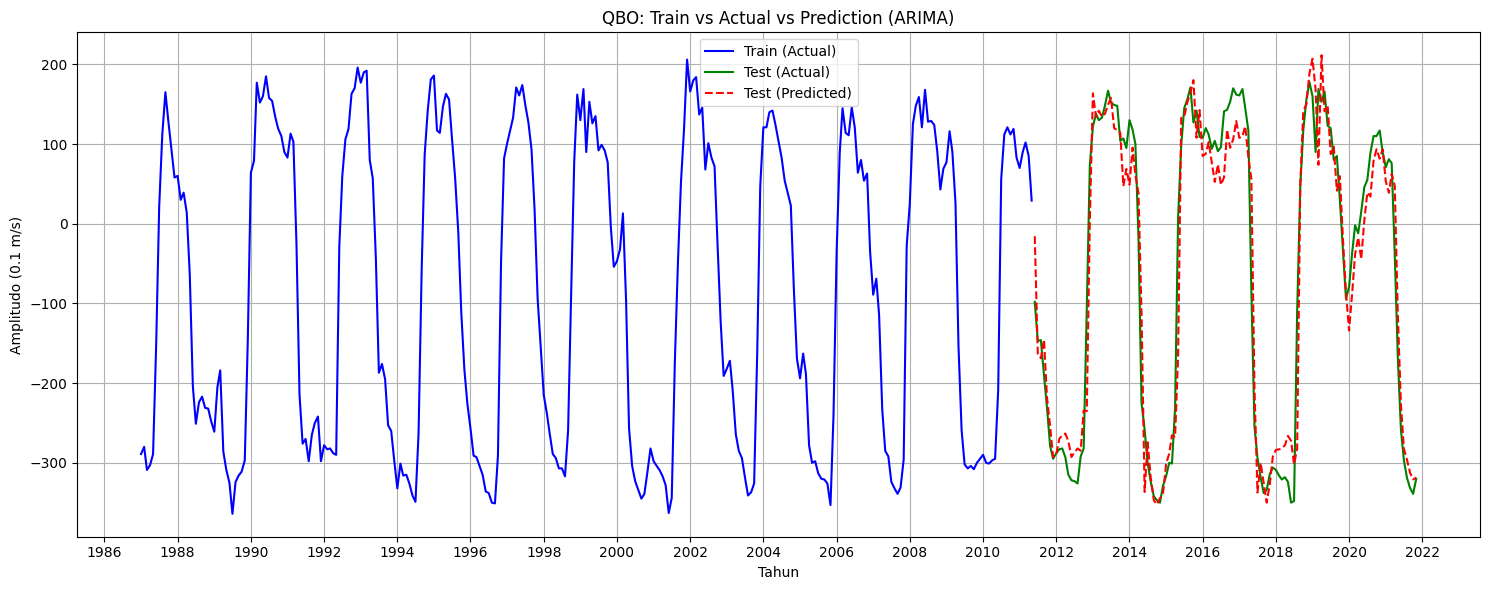

In [25]:
plt.figure(figsize=(15, 6))

plt.plot(train.index, train, label='Train (Actual)', color='blue')
plt.plot(test.index, test, label='Test (Actual)', color='green')
plt.plot(test.index, test_pred, label='Test (Predicted)', color='red', linestyle='--')

plt.title('QBO: Train vs Actual vs Prediction (ARIMA)')
plt.xlabel('Tahun')
plt.ylabel('Amplitudo (0.1 m/s)')
plt.legend()
plt.grid(True)

# Format sumbu x jadi tahun
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))

plt.tight_layout()
plt.show()

ADF Statistic: -21.218869289382916
P-Value: 0.0
✅ Residual bersifat stasioner (white noise).


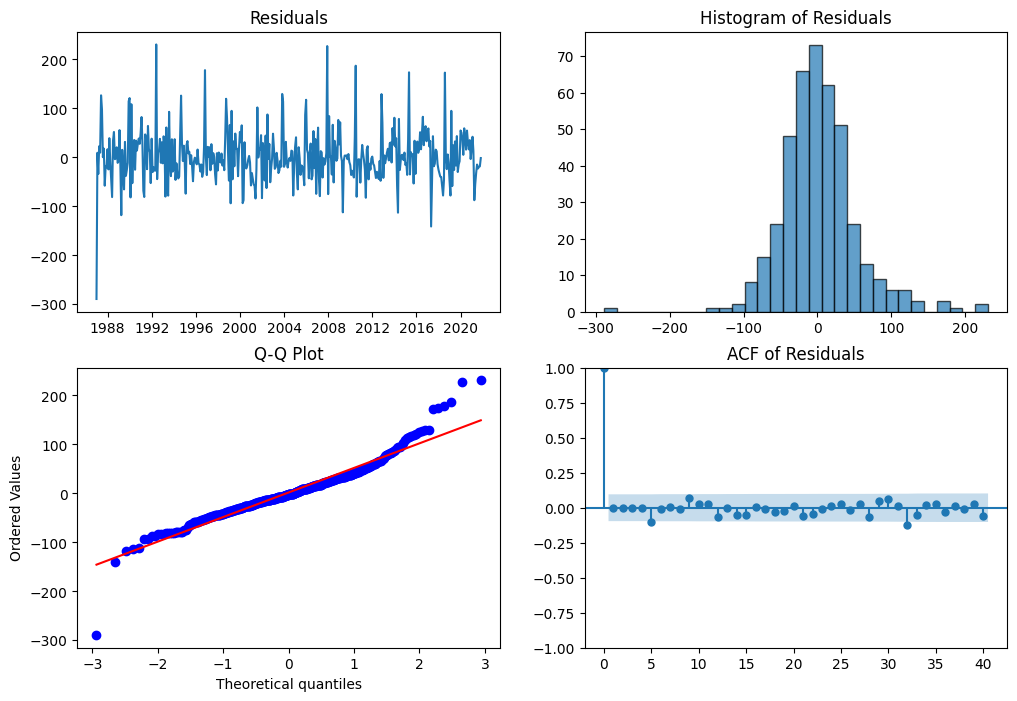

In [26]:
from scipy.stats import probplot

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ===== Analisis Residual =====
residuals = model_fit.resid

# Plot residuals
axes[0, 0].plot(residuals)
axes[0, 0].set_title("Residuals")

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor="k", alpha=0.7)
axes[0, 1].set_title("Histogram of Residuals")

# Q-Q plot
probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot")

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title("ACF of Residuals")

# Uji ADF
adf_stat, p_value, _, _, _, _ = adfuller(residuals)
print(f"ADF Statistic: {adf_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("✅ Residual bersifat stasioner (white noise).")
else:
    print("⚠️ Residual tidak stasioner. Model bisa ditingkatkan.")

In [27]:
import pandas as pd
import numpy as np

# Fungsi untuk membuat DataFrame prediksi
def save_predictions(predictions, original_data=None, filename='predictions.xlsx'):
    """
    Simpan prediksi ke Excel dengan referensi index/row number
    
    Parameters:
    - predictions: Array prediksi (numpy array atau pandas Series)
    - original_data: Data asli (untuk mendapatkan index jika ada)
    - filename: Nama file output
    """
    # Konversi ke array 1D
    preds = np.array(predictions).flatten()
    
    # Buat referensi index
    if original_data is not None and hasattr(original_data, 'index'):
        # Jika ada data asli dengan index
        index = original_data.index
    elif original_data is not None and isinstance(original_data, (np.ndarray, list)):
        # Jika data asli berupa array/list tanpa index
        index = range(len(original_data))
    else:
        # Default: nomor baris
        index = range(len(preds))
    
    # Buat DataFrame
    df = pd.DataFrame({
        'row_reference': index,
        'predicted_value': preds
    })
    
    # Simpan ke Excel
    df.to_excel(filename, index=False)
    print(f"Prediksi disimpan ke {filename}")

# Simpan prediksi training
save_predictions(train_pred, original_data=train, filename='train_predictions.xlsx')

# Simpan prediksi testing
save_predictions(test_pred, original_data=test, filename='test_predictions.xlsx')

Prediksi disimpan ke train_predictions.xlsx
Prediksi disimpan ke test_predictions.xlsx


In [28]:
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residual dari model_fit
residuals = model_fit.resid

# Pilih lags yang ingin diuji
lags = [12, 24, 36, 48]

# Jalankan uji Ljung-Box
ljung = acorr_ljungbox(residuals, lags=lags, return_df=True)

# Buat DataFrame hasil
tabel = pd.DataFrame({
    'Lags': lags,
    'Stat. value': ljung['lb_stat'].values,
    'p-value': ljung['lb_pvalue'].values
})

# Kolom Keterangan (Lolos jika p-value > 0.05)
tabel['Ket.'] = tabel['p-value'].apply(lambda x: "Lolos" if x > 0.05 else "Tidak")

# Tampilkan tabel
print("Uji White Noise")
print(tabel)

# Untuk tampilan seperti tabel di gambar (misal ingin tabel markdown atau latex):
from IPython.display import display
display(tabel.style.format({"Stat. value": "{:.6f}", "p-value": "{:.6g}"}))

Uji White Noise
   Lags  Stat. value   p-value   Ket.
0    12     9.096611  0.694657  Lolos
1    24    14.588223  0.932231  Lolos
2    36    29.323541  0.776842  Lolos
3    48    33.699569  0.941381  Lolos


,Lags,Stat. value,p-value,Ket.
0,12,9.096611,0.694657,Lolos
1,24,14.588223,0.932231,Lolos
2,36,29.323541,0.776842,Lolos
3,48,33.699569,0.941381,Lolos


In [29]:
# Ambil residual (sisa error) dari hasil fitting model SARIMA
residuals = model_fit.resid

# Tampilkan 10 nilai residual pertama
print(residuals.head(10))

# Jika ingin semua residual dalam bentuk tabel/dataframe:
import pandas as pd
residuals_df = pd.DataFrame(residuals, columns=['Residual'])
print(residuals_df)

# Atau simpan ke Excel/CSV jika ingin diolah di luar Python
# residuals_df.to_excel('residual_arima.xlsx')
# residuals_df.to_csv('residual_arima.csv')

Date
1987-01-01   -289.000000
1987-02-01      9.551494
1987-03-01    -33.803185
1987-04-01     22.918036
1987-05-01      9.815375
1987-06-01    126.798446
1987-07-01     98.403205
1987-08-01      0.614269
1987-09-01     18.062637
1987-10-01    -57.675793
dtype: float64
              Residual
Date                  
1987-01-01 -289.000000
1987-02-01    9.551494
1987-03-01  -33.803185
1987-04-01   22.918036
1987-05-01    9.815375
...                ...
2021-07-01  -14.455702
2021-08-01  -22.608230
2021-09-01  -19.190286
2021-10-01  -18.162598
2021-11-01   -1.268241

[419 rows x 1 columns]


In [30]:
print(residuals.iloc[99])  # karena index mulai dari 0

33.27128523370814


C:\Users\HP\AppData\Local\Temp\ipykernel_22300\3551718933.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='M')


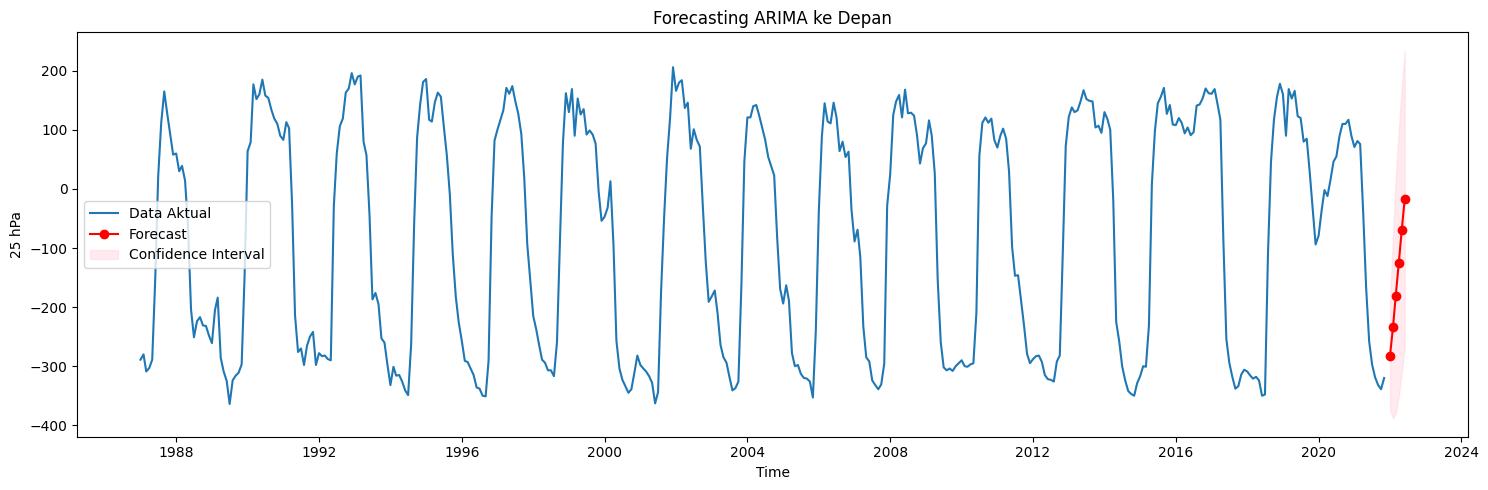

Hasil Forecasting:
2021-12-31: -282.52
2022-01-31: -233.93
2022-02-28: -180.68
2022-03-31: -125.57
2022-04-30: -70.23
2022-05-31: -16.36


In [31]:
n_forecast = 6  # Ganti dengan jumlah periode ke depan yang diinginkan
forecast = model_fit.get_forecast(steps=n_forecast)

# Ambil tanggal terakhir dari Data yang sudah datetime index
last_date = Data.index[-1]

# Untuk data bulanan, gunakan pd.DateOffset(months=1)
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_forecast, freq='M')

forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15, 5))
plt.plot(Data.index, Data['25 hPa'], label='Data Aktual')
plt.plot(forecast_index, forecast_values, color='red', marker='o', label='Forecast')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Forecasting ARIMA ke Depan')
plt.xlabel('Time')
plt.ylabel('25 hPa')
plt.legend()
plt.tight_layout()
plt.show()

print("Hasil Forecasting:")
for date, value in zip(forecast_index, forecast_values):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

Statistik Deskriptif Residual:
count    419.000000
mean       1.967981
std       51.652820
min     -289.000000
25%      -26.626113
50%       -2.093050
75%       27.667365
max      230.679927
dtype: float64


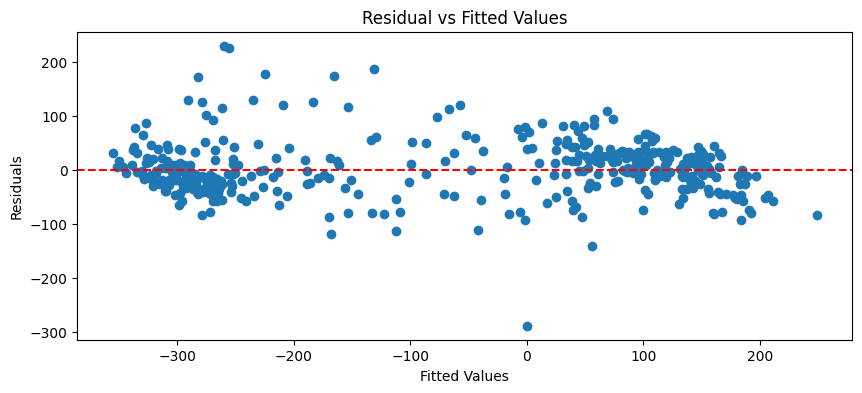

In [32]:
print("Statistik Deskriptif Residual:")
print(residuals.describe())

plt.figure(figsize=(10, 4))
plt.scatter(model_fit.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

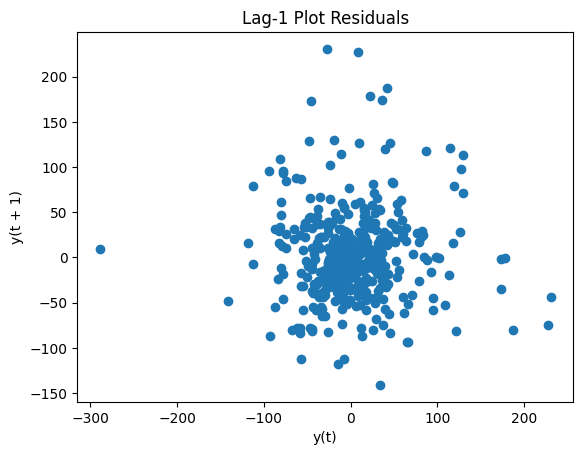

In [33]:
from pandas.plotting import lag_plot
lag_plot(residuals, lag=1)
plt.title("Lag-1 Plot Residuals")
plt.show()

In [34]:
# Install package arch jika belum ada
!pip install arch --upgrade

# Gunakan ARCH dari package yang benar
from arch import arch_model

# Uji efek ARCH (residual harus berupa array 1D atau pandas Series)
def arch_effect_test(residuals, lags=1):
    """Uji efek ARCH pada residual."""
    model = arch_model(residuals, mean='Zero', vol='ARCH', p=lags)
    res = model.fit(disp='off')
    return res.pvalues[-1]  # p-value dari koefisien ARCH

# Contoh penggunaan
p_value_arch = arch_effect_test(residuals, lags=1)
print(f"P-value uji ARCH: {p_value_arch:.4f}")

if p_value_arch < 0.05:
    print("✅ Terdapat efek ARCH (heteroskedastisitas).")
else:
    print("❌ Tidak ada efek ARCH (varians konstan).")

P-value uji ARCH: 0.1485
❌ Tidak ada efek ARCH (varians konstan).



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\HP\AppData\Local\Temp\ipykernel_22300\2507156835.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return res.pvalues[-1]  # p-value dari koefisien ARCH
